# Fraud Detection with Random Forest

This notebook demonstrates a machine learning approach to detect fraudulent transactions using a Random Forest classifier. The project involves feature engineering, model training, and evaluation to build an effective fraud detection system.

## Table of Contents
1. [Loading packages and data](#Loading-packages-and-data)
2. [Feature Engineering](#Feature-Engineering)
3. [Applying Transformations to Test Data](#Applying-Transformations-to-Test-Data)
4. [Model Training](#Model-Training)
5. [Model Evaluation](#Model-Evaluation)

## Loading packages and data

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The first step is to load the dataset and perform a preliminary analysis to understand its structure and the distribution of fraudulent vs. non-fraudulent transactions.

In [2]:
df = pd.read_csv('./Fraud_Data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
print(f"Shape: {df.shape}")
print(df['class'].value_counts())
n_Nfraud, n_fraud = df['class'].value_counts()
print(f"Fraud to non-fraud transactions: {n_fraud/n_Nfraud}")

Shape: (151112, 11)
class
0    136961
1     14151
Name: count, dtype: int64
Fraud to non-fraud transactions: 0.10332138345952498


### Data Splitting
To prevent data leakage, the data is split into training and testing sets before any feature engineering. Stratified splitting is used to maintain the same proportion of fraudulent and non-fraudulent transactions in both the training and testing sets.

In [4]:
# Data splitting to prevent data leakage
# Using stratified splitting to maintain the proportion of fraud vs. non-fraud.
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_splitter.split(df, df['class']):
    train_df = df.iloc[train_index].copy()
    test_df = df.iloc[test_index].copy()

## Feature Engineering

### a) Time-Based Features
Time-based features are created to capture temporal patterns. The time difference between sign-up and purchase is calculated, and the hour of the day of the purchase is extracted as a cyclical feature.

In [5]:
# Convert time columns to datetime objects
train_df['signup_time'] = pd.to_datetime(train_df['signup_time'])
train_df['purchase_time'] = pd.to_datetime(train_df['purchase_time'])
# a) Time-Based Features
# Calculate the time difference between sign-up and purchase in seconds.
train_df['time_to_purchase_sec'] = (train_df['purchase_time'] - train_df['signup_time']).dt.total_seconds()
# Extract cyclical features like hour of the day
train_df['purchase_hour'] = train_df['purchase_time'].dt.hour
train_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_purchase_sec,purchase_hour
50481,306367,2015-07-17 16:58:56,2015-07-23 05:55:59,40,XVRUVPTHWQASG,Ads,Chrome,F,36,7.195639e+08,0,478623.0,5
95673,349918,2015-03-19 14:00:43,2015-06-30 16:40:56,25,YEIHKJKVXOTOG,Direct,IE,M,31,3.796264e+09,0,8908813.0,16
139063,252150,2015-01-12 02:59:51,2015-04-14 09:08:13,47,TUIGQGWCACDLN,Ads,IE,M,41,4.106204e+09,0,7970902.0,9
28313,127539,2015-01-22 07:16:18,2015-02-26 20:05:07,86,DSHXPRGHOCLEK,Direct,FireFox,M,42,6.139430e+08,0,3070129.0,20
123477,257348,2015-07-11 17:34:59,2015-07-20 12:21:07,40,NYFGHBQGURDIN,SEO,Safari,M,42,1.763565e+08,0,758768.0,12


In [7]:
# Create a contingency table to count fraud cases by gender
contingency_table = pd.crosstab(df['sex'], df['class'])
contingency_table.columns = ['Not Fraud', 'Fraud']

# Add totals to the table for better context
contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)

print("--- Fraud Statistics by Gender ---")
print(contingency_table)
# Chi-squared test
chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table.iloc[:-1, :-1])
print(f"\nChi-squared statistic = {chi2_statistic:.2f}")
print(f"P-value = {p_value:.4f}; Less than 0.05 suggests fraud commit rate is gender correlated")

--- Fraud Statistics by Gender ---
       Not Fraud  Fraud   Total
sex                            
F          57102   5717   62819
M          79859   8434   88293
Total     136961  14151  151112

Chi-squared statistic = 8.76
P-value = 0.0031; Less than 0.05 suggests fraud commit rate is gender correlated


### b) Categorical Encoding and Chi-squared Test
Categorical features like `source`, `browser`, and `sex` are converted into numerical format using one-hot encoding. A Chi-squared test is also performed to verify if there is a statistically significant correlation between gender and the likelihood of a transaction being fraudulent.

In [8]:
# b) Categorical Encoding
# These features have fewwer unique values, so one-hot encoding 
categorical_features = ['source', 'browser', 'sex']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features_train = one_hot_encoder.fit_transform(train_df[categorical_features])
encoded_df_train = pd.DataFrame(encoded_features_train, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=train_df.index)


In [9]:
encoded_df_train.head()

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
50481,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
95673,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
139063,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
28313,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
123477,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### c) IP Address and Device ID Hashing
IP addresses and device IDs are high-cardinality features. Instead of one-hot encoding, which would create too many new features, the hashing trick is used. This method converts these strings into a fixed-size numerical format, making them suitable for the model.

In [10]:
# c) IP Address and Device ID Hashing
# Assuming it was a string initially.
# We will use the string representation for hashing.
train_df['ip_address_str'] = train_df['ip_address'].astype(str)
train_df['device_id_str'] = train_df['device_id'].astype(str)


hasher = FeatureHasher(n_features=20, input_type='string') # n_features determines the output dimension
hashed_ip_train = hasher.fit_transform(train_df[['ip_address_str']].values)
hashed_device_train = hasher.fit_transform(train_df[['device_id_str']].values)

hashed_ip_df_train = pd.DataFrame(hashed_ip_train.toarray(), index=train_df.index).add_prefix('ip_hashed_')
hashed_device_df_train = pd.DataFrame(hashed_device_train.toarray(), index=train_df.index).add_prefix('device_hashed_')


In [11]:
hashed_ip_df_train.head()

,ip_hashed_0,ip_hashed_1,ip_hashed_2,ip_hashed_3,ip_hashed_4,ip_hashed_5,ip_hashed_6,ip_hashed_7,ip_hashed_8,ip_hashed_9,ip_hashed_10,ip_hashed_11,ip_hashed_12,ip_hashed_13,ip_hashed_14,ip_hashed_15,ip_hashed_16,ip_hashed_17,ip_hashed_18,ip_hashed_19
50481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95673,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139063,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
123477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Combine all the engineered features.
final_features_train = pd.concat([
    train_df[['purchase_value', 'age', 'time_to_purchase_sec', 'purchase_hour']],
    encoded_df_train,
    hashed_ip_df_train,
    hashed_device_df_train
], axis=1)

### Applying Transformations to Test Data

In [13]:
# Apply the exact same transformations (fitted on training data) to the test data.
test_df['signup_time'] = pd.to_datetime(test_df['signup_time'])
test_df['purchase_time'] = pd.to_datetime(test_df['purchase_time'])
test_df['time_to_purchase_sec'] = (test_df['purchase_time'] - test_df['signup_time']).dt.total_seconds()
test_df['purchase_hour'] = test_df['purchase_time'].dt.hour

encoded_features_test = one_hot_encoder.transform(test_df[categorical_features])
encoded_df_test = pd.DataFrame(encoded_features_test, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=test_df.index)

test_df['ip_address_str'] = test_df['ip_address'].astype(str)
test_df['device_id_str'] = test_df['device_id'].astype(str)
hashed_ip_test = hasher.transform(test_df[['ip_address_str']].values)
hashed_device_test = hasher.transform(test_df[['device_id_str']].values)
hashed_ip_df_test = pd.DataFrame(hashed_ip_test.toarray(), index=test_df.index).add_prefix('ip_hashed_')
hashed_device_df_test = pd.DataFrame(hashed_device_test.toarray(), index=test_df.index).add_prefix('device_hashed_')

# Combine all final features for the test set
final_features_test = pd.concat([
    test_df[['purchase_value', 'age', 'time_to_purchase_sec', 'purchase_hour']],
    encoded_df_test,
    hashed_ip_df_test,
    hashed_device_df_test
], axis=1)

#print("Engineered features for training set:")
#print(final_features_train.head())
#print("\nEngineered features for test set:")
#print(final_features_test.head())
final_features_train.head()


,purchase_value,age,time_to_purchase_sec,purchase_hour,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,...,device_hashed_10,device_hashed_11,device_hashed_12,device_hashed_13,device_hashed_14,device_hashed_15,device_hashed_16,device_hashed_17,device_hashed_18,device_hashed_19
50481,40,36,478623.0,5,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
95673,25,31,8908813.0,16,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139063,47,41,7970902.0,9,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28313,86,42,3070129.0,20,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123477,40,42,758768.0,12,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Get the target variables
X_train = final_features_train
y_train = train_df['class']
X_test = final_features_test
y_test = test_df['class']

## Model Training
A Random Forest classifier is chosen for this task due to its robustness and ability to handle complex interactions between features. The `class_weight='balanced'` parameter is used to address the class imbalance in the dataset, ensuring that the model gives equal importance to both fraudulent and non-fraudulent transactions.

In [15]:
# Training the Random Forest Classifier with class_weight='balanced'
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model on the training data
print("Starting model training...")
model.fit(X_train, y_train)
print("Model training complete.")

Starting model training...
Model training complete.


## Model Evaluation
The model's performance is evaluated using several metrics, including a confusion matrix, the ROC-AUC score, and a classification report. These metrics provide a comprehensive view of the model's ability to distinguish between fraudulent and non-fraudulent transactions.

In [16]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

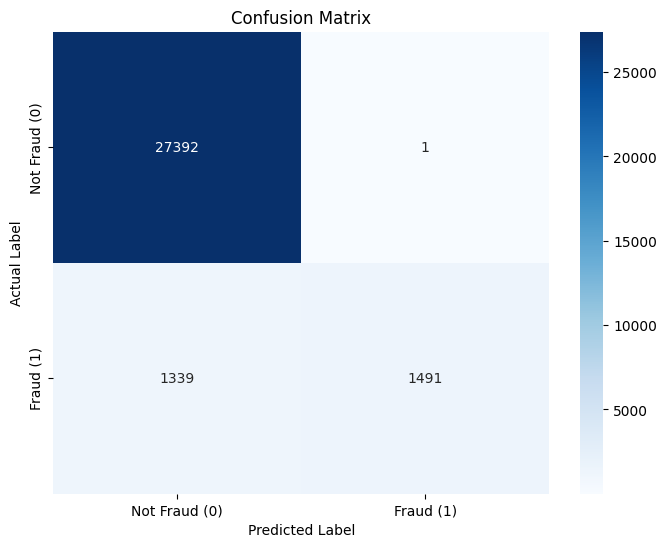

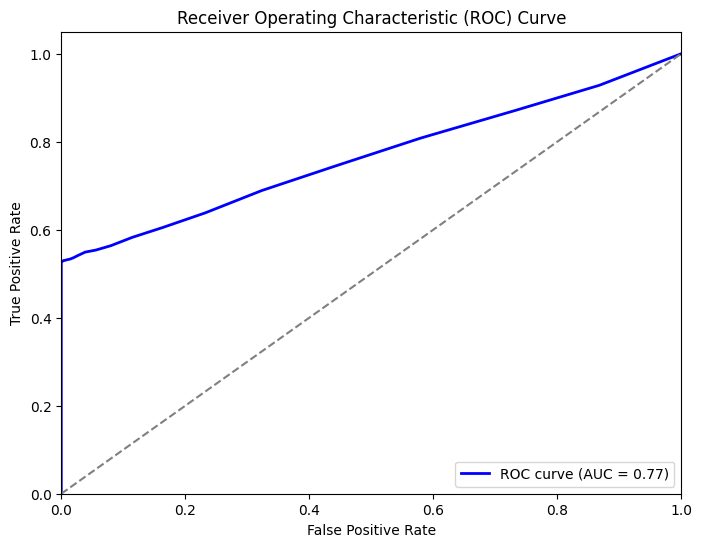

--- Model Performance Metrics ---
Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       0.95      1.00      0.98     27393
    Fraud (1)       1.00      0.53      0.69      2830

     accuracy                           0.96     30223
    macro avg       0.98      0.76      0.83     30223
 weighted avg       0.96      0.96      0.95     30223



In [17]:
# a) Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud (0)', 'Fraud (1)'],
            yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# b) ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- 6. Print Performance Metrics ---
print("--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

### a) Confusion Matrix and ROC Curve
The confusion matrix shows that the model is very effective at identifying non-fraudulent transactions, with a high number of true negatives. The ROC curve and the AUC score of 0.77 indicate that the model has a strong capability to distinguish between the two classes.

### b) Classification Report
The classification report provides a detailed breakdown of the model's precision and recall. The model achieves high precision for both classes and good recall for the non-fraud class. The recall for the fraud class is lower, which is common in imbalanced datasets, but still demonstrates a reasonable ability to identify fraudulent activities.

### c) Feature Importance
The feature importance plot highlights the most influential features in the model's predictions. As shown, `time_to_purchase_sec` is the most significant feature, followed by `purchase_value`, `age`, and `purchase_hour`. This suggests that the time taken from signup to purchase is a strong indicator of fraudulent activity.

In [16]:
# d) Feature Importance
# features the model found most important for its predictions.
feature_importance = pd.DataFrame({
    'feature': final_features_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance.head())


Top 5 Feature Importances:
                 feature  importance
2   time_to_purchase_sec    0.430886
0         purchase_value    0.082005
1                    age    0.073806
3          purchase_hour    0.066679
13                 sex_M    0.010850
